In [1]:
from os import path
import numpy as np
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# read iris.csv
legend = pd.read_csv('legend.csv').to_numpy()

# split into label and identifiers
tmp_labels = legend[:, 2]
tmp_pic_names = legend[:, 1]
tmp_labels = np.array([i.lower() for i in tmp_labels])
print(tmp_pic_names.shape)
print(tmp_pic_names.shape)


(13690,)
(13690,)


In [3]:
!unzip images.zip

Streaming output truncated to the last 5000 lines.
 extracting: images/Lloyd_Richards_0001.jpg  
 extracting: images/Lloyd_Ward_0001.jpg  
 extracting: images/Lloyd_Ward_0002.jpg  
  inflating: images/Lois_Smart_0001.jpg  
 extracting: images/Lokendra_Bahadur_Chand_0001.jpg  
 extracting: images/Lonnie_Donegan_0001.jpg  
 extracting: images/Lon_Kruger_0001.jpg  
 extracting: images/Lon_Kruger_0002.jpg  
 extracting: images/Lope_Mendoza_0001.jpg  
 extracting: images/Lord_Hutton_0001.jpg  
 extracting: images/Lord_Hutton_0002.jpg  
 extracting: images/Loretta_Lynn_Harper_0001.jpg  
 extracting: images/Lori_Berenson_0001.jpg  
 extracting: images/Lorne_Michaels_0001.jpg  
 extracting: images/Lorraine_Bracco_0001.jpg  
 extracting: images/Lorraine_Fenton_0001.jpg  
 extracting: images/Louisa_Baileche_0001.jpg  
 extracting: images/Louis_Van_Gaal_0001.jpg  
 extracting: images/Lou_Lang_0001.jpg  
 extracting: images/Lou_Piniella_0001.jpg  
 extracting: images/Lou_Piniella_0002.jpg  
 extra

In [4]:
#Data Preprocessing
folder = 'images/'
imgs = []
for name in tmp_pic_names[:]:
    
    #read the img
    img = cv2.imread(folder+name)
    #resize
    final_img = cv2.resize(img, (128,128))
    
    imgs.append(final_img)

In [5]:
# autoencode labels for training
onehot_encoder = OneHotEncoder(sparse=False)
labels = onehot_encoder.fit_transform(tmp_labels.reshape(-1, 1))

# feature list for reverse transform
print(onehot_encoder.get_feature_names())

['x0_anger' 'x0_contempt' 'x0_disgust' 'x0_fear' 'x0_happiness'
 'x0_neutral' 'x0_sadness' 'x0_surprise']


In [6]:
# save processed data for later use
np.save('input_incep_v3', imgs)
np.save('labels_incep_v3', labels)

In [7]:
input = np.load('input_incep_v3.npy')
label = np.load('labels_incep_v3.npy')

In [12]:
#import model from keras
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))


CLASSES = label.shape[1]
x = base_model.output                          # The output layer of the googleNet
x = GlobalAveragePooling2D(name='avg_pool')(x) # This layer is used to downsample the features
x = Dropout(0.4)(x) 

predictions = Dense(CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False # Set this to True if you want to re-train the entire network.

In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
from sklearn.model_selection import train_test_split
#split out the test data
X_train, X_test, y_train, y_test = train_test_split(input, label, test_size=0.33, random_state=0)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(9172, 128, 128, 3)
(9172, 8)
(4518, 128, 128, 3)
(4518, 8)


In [15]:
EPOCHS = 1000
STEPS_PER_EPOCH = 2
MODEL_FILE = 'final_test1.model'

history = model.fit(
    x = X_train, y = y_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_split= 0.2,
    shuffle = True)
  
model.save(MODEL_FILE)

Epoch 1/1000
2/2 [==============================] - 12s 6s/step - loss: 75.6247 - accuracy: 0.3173 - val_loss: 82.8329 - val_accuracy: 0.4158
Epoch 2/1000
2/2 [==============================] - 3s 1s/step - loss: 97.5382 - accuracy: 0.4603 - val_loss: 42.4476 - val_accuracy: 0.4169
Epoch 3/1000
2/2 [==============================] - 3s 2s/step - loss: 61.9356 - accuracy: 0.4496 - val_loss: 50.2333 - val_accuracy: 0.4174
Epoch 4/1000
2/2 [==============================] - 3s 2s/step - loss: 61.3196 - accuracy: 0.4518 - val_loss: 39.6905 - val_accuracy: 0.4169
Epoch 5/1000
2/2 [==============================] - 3s 2s/step - loss: 55.0583 - accuracy: 0.4430 - val_loss: 33.7730 - val_accuracy: 0.4174
Epoch 6/1000
2/2 [==============================] - 3s 2s/step - loss: 51.6183 - accuracy: 0.4376 - val_loss: 33.2852 - val_accuracy: 0.4169
Epoch 7/1000
2/2 [==============================] - 3s 2s/step - loss: 51.7824 - accuracy: 0.4371 - val_loss: 30.4167 - val_accuracy: 0.4185
Epoch 8/1000

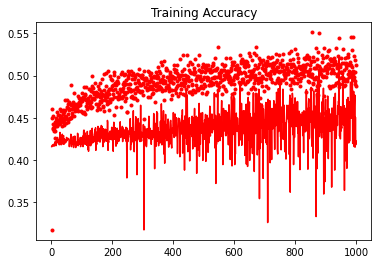

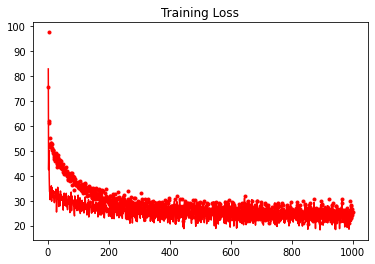

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.plot(epochs, acc,'r.')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.plot(epochs,loss,'r.')
plt.title("Training Loss")
plt.show()